In [19]:
import pandas as pd
import numpy as np
import os
import torch

def load_and_scale_data(path_2d, path_3d):
    """
    Loads and scales 2D input and 3D output data from CSV files.

    Args:
        path_2d (str): Path to the folder containing 2D data CSV files.
        path_3d (str): Path to the folder containing 3D data CSV files.

    Returns:
        torch.Tensor: Scaled 2D input data (num_objects, 21).
        torch.Tensor: Scaled 3D output data (num_objects, 31).
        dict: Scaling parameters for de-normalizing predictions.
    """
    input_2d_data = []
    output_3d_data = []

    # Read all CSV files from 2D and 3D folders
    for file_2d, file_3d in zip(sorted(os.listdir(path_2d)), sorted(os.listdir(path_3d))):
        csv_2d = pd.read_csv(os.path.join(path_2d, file_2d), header=None)
        csv_3d = pd.read_csv(os.path.join(path_3d, file_3d), header=None)
        
        # Row by row processing
        for index in range(len(csv_2d)):
            input_row = csv_2d.iloc[index].values.astype(float)  # Extract 2D row
            output_row = csv_3d.iloc[index].values.astype(float)  # Extract 3D row
            input_2d_data.append(input_row)
            output_3d_data.append(output_row)

    input_2d_tensor = torch.tensor(input_2d_data, dtype=torch.float32)
    output_3d_tensor = torch.tensor(output_3d_data, dtype=torch.float32)

    # Scale output data
    max_position = 10.0  # Assume max pos_x, pos_y, pos_z is ±10
    max_rotation = 360.0  # Assume rotation is in degrees
    max_keypoints = 10.0  # Assume keypoints are within ±10

    scaling_factors = torch.tensor(
        [1.0] + [max_position, max_position, max_position] + 
        [max_rotation, max_rotation, max_rotation] + 
        [max_keypoints] * 24,
        dtype=torch.float32
    )

    output_3d_tensor_scaled = output_3d_tensor / scaling_factors

    return input_2d_tensor, output_3d_tensor_scaled, scaling_factors

# Paths to data directories
path_2d = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\5_objects_and_edges\2d_data"
path_3d = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\5_objects_and_edges\3d_data"

# Load and scale data
input_2d_tensor, output_3d_tensor, scaling_factors = load_and_scale_data(path_2d, path_3d)
print(f"Loaded 2D data shape: {input_2d_tensor.shape}")
print(f"Scaled 3D data shape: {output_3d_tensor.shape}")


Loaded 2D data shape: torch.Size([19803, 21])
Scaled 3D data shape: torch.Size([19803, 31])


In [20]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer2DTo3D(nn.Module):
    def __init__(self, input_dim=21, output_dim=31, d_model=128, nhead=8, num_encoder_layers=6, dim_feedforward=512):
        super(Transformer2DTo3D, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward),
            num_layers=num_encoder_layers
        )
        self.fc = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, output_dim)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, d_model)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Aggregate sequence for regression
        x = self.fc(x)
        return x

print("Model definition loaded.")


Model definition loaded.


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Prepare dataset and dataloader
dataset = TensorDataset(input_2d_tensor, output_3d_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, optimizer, loss, and scheduler
model = Transformer2DTo3D(input_dim=21, output_dim=31)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Early stopping configuration
early_stopping_patience = 10
min_val_loss = float('inf')
patience_counter = 0

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch in dataloader:
        x, y = batch
        x = x.unsqueeze(1)  # Ensure input has the correct shape for the Transformer
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Average epoch loss
    epoch_loss /= len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss:.4f}")
    
    # Learning rate scheduling
    scheduler.step(epoch_loss)
    
    # Early stopping logic
    if epoch_loss < min_val_loss:
        min_val_loss = epoch_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), "transformer_2d_to_3d_scaled.pth")
        print(f"Model improved and saved at epoch {epoch + 1}")
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}/{early_stopping_patience}")
    
    # Stop training if patience is exceeded
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered. Training stopped.")
        break

print("Training completed.")


c:\Users\sakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


KeyboardInterrupt: 

In [28]:
import pandas as pd
import torch

# Paths to model and data
model_path = "transformer_2d_to_3d_scaled.pth"
data_csv_path = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\5_objects_and_edges\2d_data\3001.csv"

# Load the model
model = Transformer2DTo3D(input_dim=21, output_dim=31)
model.load_state_dict(torch.load(model_path))
model.eval()
print("Model weights loaded for inference.")

# Define scaling factors for output
max_position = 10.0  # Assume max pos_x, pos_y, pos_z is ±10
max_rotation = 360.0  # Assume rotation is in degrees
max_keypoints = 10.0  # Assume keypoints are within ±10

scaling_factors = torch.tensor(
    [1.0] + [max_position, max_position, max_position] +
    [max_rotation, max_rotation, max_rotation] +
    [max_keypoints] * 24,
    dtype=torch.float32
)

# Load and preprocess data from a CSV file
csv_data = pd.read_csv(data_csv_path, header=None)
input_2d_data = torch.tensor(csv_data.values.astype(float), dtype=torch.float32)

# Ensure correct input shape for the model
input_2d_data = input_2d_data.unsqueeze(1)  # Add seq_len dimension

# Inference function with scaling validation
def run_inference_and_rescale(model, input_data, scaling_factors):
    """
    Runs inference and rescales the predictions to original output scale.

    Args:
        model (Transformer2DTo3D): Trained model.
        input_data (torch.Tensor): 2D input data (batch_size, seq_len, input_dim).
        scaling_factors (torch.Tensor): Scaling factors for rescaling predictions.

    Returns:
        torch.Tensor: Rescaled 3D outputs.
    """
    with torch.no_grad():
        predictions_scaled = model(input_data)  # Get scaled predictions
        predictions = predictions_scaled * scaling_factors  # Rescale to original range
    # Validate rescaling
    assert predictions.min().item() >= -10.0, "Predictions out of expected range (too low)"
    assert predictions.max().item() <= 10.0 + 360.0, "Predictions out of expected range (too high)"
    return predictions

# Run inference
predictions = run_inference_and_rescale(model, input_2d_data, scaling_factors)
print("Predictions:", predictions)

# Optional: Add additional checks for stats
print("Input Data Stats")
print(f"Mean: {input_2d_data.mean(dim=0)}")
print(f"Std Dev: {input_2d_data.std(dim=0)}")


Model weights loaded for inference.
Predictions: tensor([[ 5.8969e+00,  3.3757e-01, -4.2841e-01,  2.6993e-02, -3.1073e-03,
          1.7827e+02,  2.7370e-02,  6.0255e-01,  1.5265e-01,  2.1799e-01,
          6.0622e-01,  1.6691e-01, -1.6376e-01,  9.0997e-02,  1.5553e-01,
         -1.5494e-01,  8.3262e-02,  1.6744e-01,  2.2089e-01,  6.0782e-01,
         -4.8220e-01,  2.2043e-01,  5.9531e-01, -4.8399e-01, -1.5452e-01,
          8.9520e-02, -4.8687e-01, -1.5671e-01,  8.4591e-02, -4.8739e-01,
          2.2135e-01],
        [ 5.8969e+00,  3.3757e-01, -4.2841e-01,  2.6993e-02, -3.1073e-03,
          1.7827e+02,  2.7370e-02,  6.0255e-01,  1.5265e-01,  2.1799e-01,
          6.0622e-01,  1.6691e-01, -1.6376e-01,  9.0997e-02,  1.5553e-01,
         -1.5494e-01,  8.3262e-02,  1.6744e-01,  2.2089e-01,  6.0782e-01,
         -4.8220e-01,  2.2043e-01,  5.9531e-01, -4.8399e-01, -1.5452e-01,
          8.9520e-02, -4.8687e-01, -1.5671e-01,  8.4591e-02, -4.8739e-01,
          2.2135e-01],
        [ 5.8969e

c:\Users\sakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\sakar\AppData\Local\Temp\ipykernel_22708\942959876.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objec

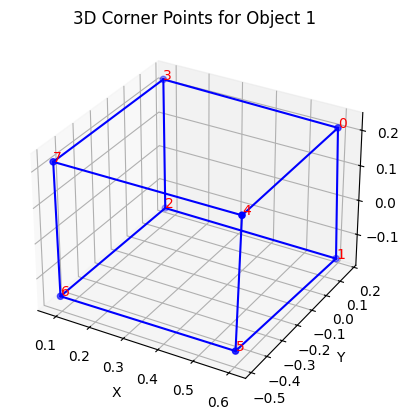

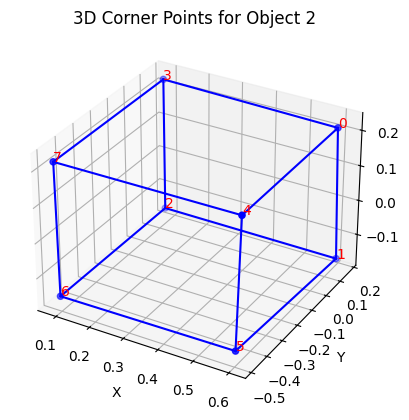

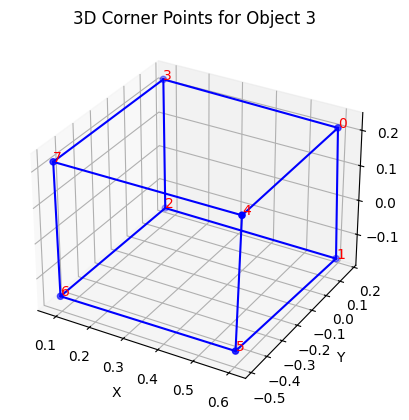

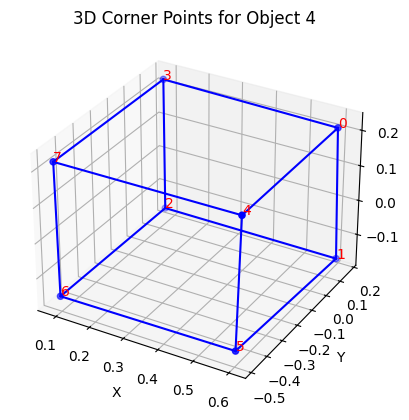

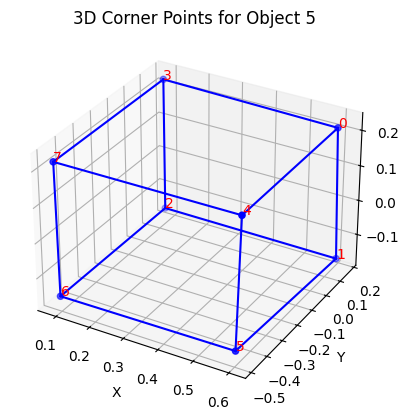

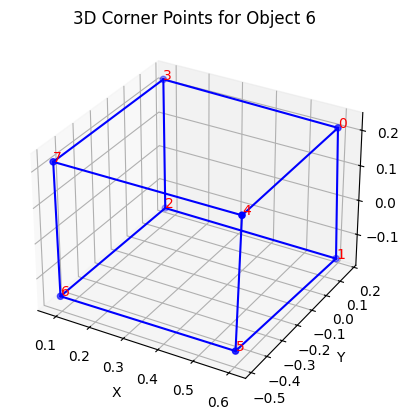

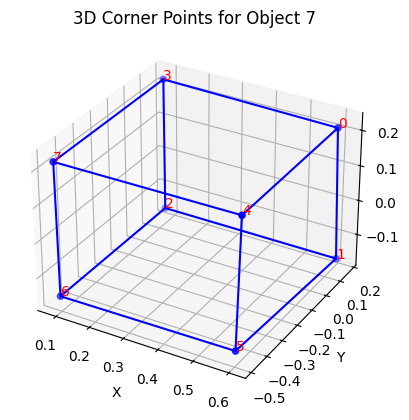

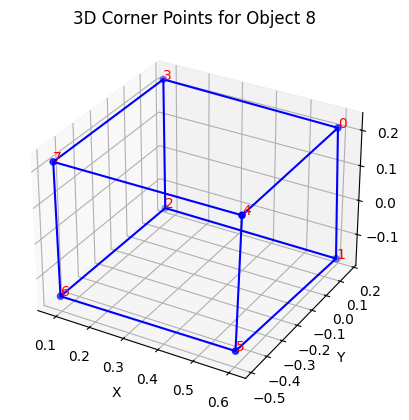

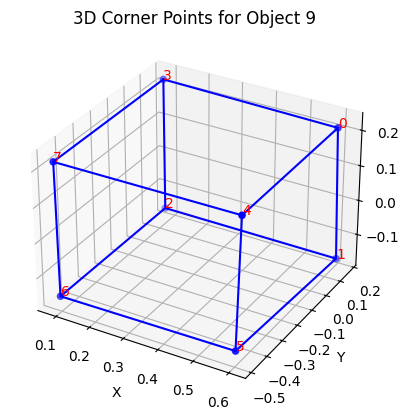

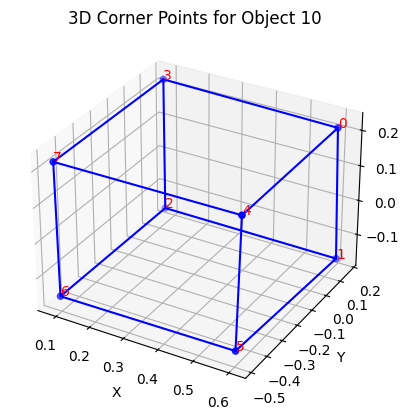

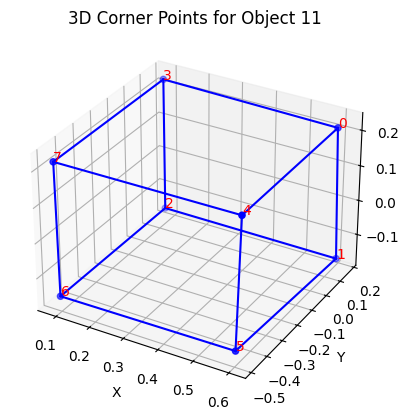

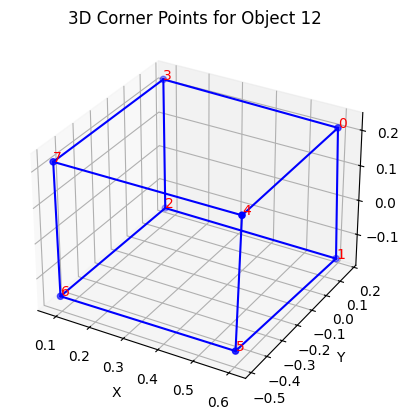

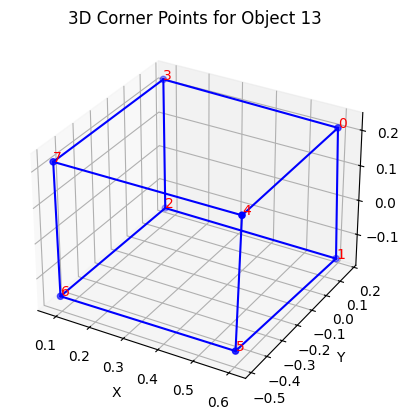

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Visualization function
def plot_3d_corners(predictions_3d):
    """
    Plots 3D corner points from predictions and connects them to form a cube structure.

    Args:
        predictions_3d (torch.Tensor): Predictions from the model, where the last 24 elements
                                       correspond to 8 corner points (3D coordinates per corner).
    """
    if predictions_3d is None or len(predictions_3d) == 0:
        print("No predictions to plot.")
        return

    # Extract the last 24 elements for the 8 corner points (each corner has 3 coordinates)
    corner_predictions = predictions_3d[:, -24:].view(-1, 8, 3)

    for i, corners in enumerate(corner_predictions):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        x, y, z = corners[:, 0], corners[:, 1], corners[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        for j, (x_coord, y_coord, z_coord) in enumerate(corners):
            ax.text(x_coord, y_coord, z_coord, f"{j}", color="red")

        connections = [
            (0, 1), (1, 2), (2, 3), (3, 0),
            (4, 5), (5, 6), (6, 7), (7, 4),
            (0, 4), (1, 5), (2, 6), (3, 7)
        ]

        for start, end in connections:
            ax.plot(
                [x[start], x[end]],
                [y[start], y[end]],
                [z[start], z[end]],
                'b-'
            )

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.title(f"3D Corner Points for Object {i + 1}")
        plt.show()

# Plot results
plot_3d_corners(predictions)
